In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import random as rn
warnings.filterwarnings("ignore")

In [2]:

# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


In [3]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [4]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [5]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [6]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [7]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [8]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [9]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [10]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [11]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [12]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [13]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [14]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [15]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [16]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [17]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [18]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [19]:
def plot_performance_metrics(df , colors=None, labels = None, y_min = 0.0, frame_color = 'gray', frame_width = 0.5, x_label_rotation = 45, tick_size = 14,legend_fontsize = 12,
                            legend_labels = None, legend_loc = 'upper center', legend_bbox_to_anchor=(0.5, -0.2), legend_ncol=4, save=False, save_path=None):

    # Default values
    default_colors = ['#5E0B8A', '#00A7E1', '#BDDA57', '#FF8C00']
    default_labels = ['accuracy', 'balanced accuracy','cluster accuracy', 'macro F1', 'median F1',
                      'median precision', 'median recall','MCC', 'ARI', "Cohen's kappa"]
    default_legend_labels =['scATAcat', 'Seurat label transfer', 'Cellcano', 'EpiAnno']

    # Use default if None is passed
    colors = default_colors if colors is None else colors
    labels = default_labels if labels is None else labels
    legend_labels = default_legend_labels if legend_labels is None else legend_labels
  
    df.columns = labels
    df.index = legend_labels
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    n_bins = 100  # Increase this number for a smoother gradient
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    ax = df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12, colormap=cmap)
    ax.set_ylim(ymin=y_min)
    # Change plot frame to gray and adjust linewidth
    spine_color = 'gray'
    linewidth = frame_width # Adjust the linewidth as needed
    for spine in ax.spines.values():
        spine.set_color(spine_color)
        spine.set_linewidth(linewidth)
    ax.legend(legend_labels,fontsize=legend_fontsize, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor,
          fancybox=False, shadow=False, ncol=legend_ncol, frameon=False)
    plt.xticks(rotation=45)
    plt.tick_params(axis='both', which='major', labelsize=tick_size)

    if save == False:
        plt.show()
    else:
        if save_path == None:
            print("specify the save_path directory")
        else:
            plt.savefig(save_path, bbox_inches='tight', transparent=True)

### silver ground truth annotations - from original publication


In [20]:
ground_truth_annotations = pd.read_csv("../../../data/Granja2019/PBMC_D10T1/03_cellIDs_and_annotations/metadata.csv")

In [21]:
ground_truth_annotations = ground_truth_annotations[["BioClassification", "Barcode"]]
ground_truth_annotations[['cluster_id', 'annotation']] = ground_truth_annotations['BioClassification'].str.split('_', n=1, expand=True)
ground_truth_annotations.index=ground_truth_annotations['Barcode']
ground_truth_annotations.index.name = None
ground_truth_annotations.columns = ["BioClassification","cell_IDs","cluster_id","annotation"]

In [22]:
ground_truth_renaming_dict={'B':'Bcell',
 'CD14.Mono.1':'Mono',
 'CD14.Mono.2':'Mono',
 'CD4.M':'CD4Tcell',
 'CD4.N1':'CD4Tcell',
 'CD4.N2':'CD4Tcell',
 'CD8.CM':'CD8Tcell',
 'CD8.EM':'CD8Tcell',
 'CD8.N':'CD8Tcell',
 'Early.Baso':'Basofil',
 'GMP':'GMP',
 'HSC':'HSC/MPP',
 'NK':'NKcell',
 'Plasma':'Plasmacell',
 'Unk':'Unknown',
 'cDC':'DC',
 'pDC':'DC',
 'CLP.1': 'CLP',
 'CLP.2': 'CLP',
 'CMP.LMPP': 'CMP/LMPP',
 'Early.Eryth': 'Ery',
 'GMP.Neut': 'GMP',
 'Late.Eryth': 'Ery',
 'Pre.B': 'CLP'}

In [23]:
ground_truth_annotations= ground_truth_annotations.assign(ground_truth_annotations_simplified=list(ground_truth_annotations['annotation'].map(ground_truth_renaming_dict)))
ground_truth_annotations.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
TCAGGGCAGGGCATTG-1,21_CD4.N2,TCAGGGCAGGGCATTG-1,21,CD4.N2,CD4Tcell
GTTCAAGCAGTTACAC-1,22_CD4.M,GTTCAAGCAGTTACAC-1,22,CD4.M,CD4Tcell
CATTCCGGTGATAACA-1,22_CD4.M,CATTCCGGTGATAACA-1,22,CD4.M,CD4Tcell
GCGTTGGTCCAGTTAG-1,21_CD4.N2,GCGTTGGTCCAGTTAG-1,21,CD4.N2,CD4Tcell
TCAAAGCCAAGCACTT-1,26_Unk,TCAAAGCCAAGCACTT-1,26,Unk,Unknown


In [24]:
ground_truth_annotations_known = ground_truth_annotations[ground_truth_annotations['ground_truth_annotations_simplified']!= "Unknown"]

In [25]:
ground_truth_annotations.shape

(2891, 5)

In [26]:
ground_truth_annotations.annotation.value_counts()

annotation
CD14.Mono.2    867
CD4.N2         613
CD4.M          434
Unk            270
B              221
NK             168
CD8.CM         107
CD8.EM          83
cDC             67
Plasma          21
pDC             15
Early.Baso       8
CD14.Mono.1      7
CD4.N1           6
GMP              2
HSC              1
CD8.N            1
Name: count, dtype: int64

In [27]:
ground_truth_annotations.ground_truth_annotations_simplified.value_counts()

ground_truth_annotations_simplified
CD4Tcell      1053
Mono           874
Unknown        270
Bcell          221
CD8Tcell       191
NKcell         168
DC              82
Plasmacell      21
Basofil          8
GMP              2
HSC/MPP          1
Name: count, dtype: int64

In [28]:
ground_truth_annotations_known.shape

(2621, 5)

### seurat annotations

In [29]:
seurat_integration_annotations = pd.read_csv("../../../results/Fig6-Granja_PBMC_scATAC/Fig6-apply_seurat_label_transfer/Granja2019_PBMC_seurat_label_transfer_annotations.csv")
seurat_integration_annotations.columns = ["cell_IDs", "label_transfer_annotations"]
seurat_integration_annotations.index = seurat_integration_annotations.cell_IDs
seurat_integration_annotations.index.name = None
seurat_integration_annotations

,cell_IDs,label_transfer_annotations
TGCATGACAGGCTACC-1,TGCATGACAGGCTACC-1,CD4 T
GGTGTCGCATGGTATC-1,GGTGTCGCATGGTATC-1,CD4 T
TGACAACTCGCAAGCC-1,TGACAACTCGCAAGCC-1,CD8 T
GTTGGGCCATGGCCGT-1,GTTGGGCCATGGCCGT-1,B
GCCATAATCATACTTC-1,GCCATAATCATACTTC-1,CD8 T
...,...,...
AACTGTGGTGGACTGA-1,AACTGTGGTGGACTGA-1,Mono
AGTGCGCCACGATTAC-1,AGTGCGCCACGATTAC-1,Mono
TGCTTCGCATGGCCTG-1,TGCTTCGCATGGCCTG-1,Mono
AGCGATTAGAGAAGCA-1,AGCGATTAGAGAAGCA-1,Mono


In [30]:
set(seurat_integration_annotations.label_transfer_annotations)

{'B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'}

In [31]:
seurat_renaming_dict={'CD4 T':'CD4Tcell', 
            'CD8 T':'CD8Tcell',
            'pDC': 'DC',
            'NK' : 'NKcell',
            'B':'Bcell',
            'other':'other',
            'other T':'otherT'}

seurat_integration_annotations = seurat_integration_annotations.replace({"label_transfer_annotations": seurat_renaming_dict})
seurat_integration_annotations.head()

,cell_IDs,label_transfer_annotations
TGCATGACAGGCTACC-1,TGCATGACAGGCTACC-1,CD4Tcell
GGTGTCGCATGGTATC-1,GGTGTCGCATGGTATC-1,CD4Tcell
TGACAACTCGCAAGCC-1,TGACAACTCGCAAGCC-1,CD8Tcell
GTTGGGCCATGGCCGT-1,GTTGGGCCATGGCCGT-1,Bcell
GCCATAATCATACTTC-1,GCCATAATCATACTTC-1,CD8Tcell


### scATAcat annotations

In [32]:
scATAcat_annotations = pd.read_csv("../../../results/Fig6-Granja_PBMC_scATAC/Fig6-apply_scATAcat/outputs/scATAcat_annotations.csv", index_col=0)
scATAcat_annotations.index.name = None
scATAcat_annotations.columns = ['leiden_1', 'scATAcat_annotation','cell_IDs']
scATAcat_annotations

,leiden_1,scATAcat_annotation,cell_IDs
AAACGAAAGAGCTCCC-1,7,NKcell,AAACGAAAGAGCTCCC-1
AAACGAACAACAACTC-1,3,CD4Tcell,AAACGAACAACAACTC-1
AAACGAACAACTACTG-1,4,Bcell,AAACGAACAACTACTG-1
AAACGAACACCACGAC-1,0,Mono,AAACGAACACCACGAC-1
AAACGAACAGGAGCAT-1,3,CD4Tcell,AAACGAACAGGAGCAT-1
...,...,...,...
TTTGTGTCAAGTCCTA-1,0,Mono,TTTGTGTCAAGTCCTA-1
TTTGTGTCAGAATGCG-1,0,Mono,TTTGTGTCAGAATGCG-1
TTTGTGTGTGCGTCCA-1,2,CD4Tcell,TTTGTGTGTGCGTCCA-1
TTTGTGTTCCACGGCA-1,1,CD4Tcell,TTTGTGTTCCACGGCA-1


In [33]:
renaming_dict={'CD4Tcell':'CD4Tcell', 
            'CD8Tcell':'CD8Tcell',
            'pDC': 'DC',
            'NKcell' : 'NKcell',
            'Bcell':'Bcell'}

scATAcat_annotations = scATAcat_annotations.replace({"scATAcat_annotation": renaming_dict})
scATAcat_annotations.head()

,leiden_1,scATAcat_annotation,cell_IDs
AAACGAAAGAGCTCCC-1,7,NKcell,AAACGAAAGAGCTCCC-1
AAACGAACAACAACTC-1,3,CD4Tcell,AAACGAACAACAACTC-1
AAACGAACAACTACTG-1,4,Bcell,AAACGAACAACTACTG-1
AAACGAACACCACGAC-1,0,Mono,AAACGAACACCACGAC-1
AAACGAACAGGAGCAT-1,3,CD4Tcell,AAACGAACAGGAGCAT-1


In [34]:
scATAcat_annotations.shape

(2682, 3)

In [35]:
scATAcat_annotations.index.str.contains('GCGTTGGTCGGAGTTT-1').any()

True

### Cellcano annotations

In [36]:
Cellcano_annotations = pd.read_csv("../../../results/Fig6-Granja_PBMC_scATAC/Fig6-apply_Cellcano/output_Celcano_Granja2019_PBMC_scATAC/Celcano_predict_Granja2019_PBMC_scATACcelltypes.csv")

In [37]:
Cellcano_annotations.head()

,Unnamed: 0,pred_celltype,firstround_pred_celltype,entropy
0,GSM4138893_scATAC_PBMC_D10T1_liftOverhg38_no_c...,CM-CD8T,Mat-NK1,1.390348
1,GSM4138893_scATAC_PBMC_D10T1_liftOverhg38_no_c...,Mono1,Mono1,1.349125
2,GSM4138893_scATAC_PBMC_D10T1_liftOverhg38_no_c...,Mono1,Mono1,0.085966
3,GSM4138893_scATAC_PBMC_D10T1_liftOverhg38_no_c...,Mono1,Mono1,1.686113
4,GSM4138893_scATAC_PBMC_D10T1_liftOverhg38_no_c...,Mono1,Mono1,1.424064


In [38]:
Cellcano_annotations[['prefix', 'cell_IDs']] = Cellcano_annotations.iloc[:,0].str.split("#", n=1, expand=True)
Cellcano_annotations = Cellcano_annotations[["cell_IDs", "pred_celltype"]]
Cellcano_annotations.columns = ["cell_IDs", "Cellcano_annotations"]
Cellcano_annotations.index =Cellcano_annotations["cell_IDs"]
Cellcano_annotations.index.name = None
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations
GTGTGATCAAGGAAGA-1,GTGTGATCAAGGAAGA-1,CM-CD8T
GCACGCATCCAGGTCG-1,GCACGCATCCAGGTCG-1,Mono1
GGGAACAGTACAAGCG-1,GGGAACAGTACAAGCG-1,Mono1
AAAGATGTCTCTGAGA-1,AAAGATGTCTCTGAGA-1,Mono1
CTAGGATGTCTCTGCT-1,CTAGGATGTCTCTGCT-1,Mono1


In [39]:
Cellcano_annotations.Cellcano_annotations.value_counts()

Cellcano_annotations
Mono2       959
Basofil     475
N-Treg      425
M-CD4T      382
N-CD8T1     304
Mat-NK1     183
Memory-B    170
EM-CDT8     154
Naive-B      95
Mono1        74
CM-CD8T      72
Plasma-B     44
GDelta-T     35
cDC          27
pDC          11
N-CD8T3       2
N-CD4T1       1
Name: count, dtype: int64

In [40]:
Cellcano_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
Cellcano_annotations_simplified  =['HSC/MPP','MEP','CMP/LMPP','CMP/LMPP','CLP','CLP','CLP','GMP','GMP','DC','DC','Mono','Mono','Bcell','Bcell','Bcell','Basofil','NKcell','NKcell','NKcell','CD4Tcell','CD4Tcell','Treg','CD4Tcell','Treg','CD8Tcell','CD8Tcell','CD8Tcell','CD8Tcell','CD8Tcell','gdT']
Cellcano_annotations_simplified_dict = dict(zip(Cellcano_annotations_, Cellcano_annotations_simplified))

print(Cellcano_annotations_simplified_dict)

{'HSC/MPP': 'HSC/MPP', 'MEP': 'MEP', 'CMP/BMP': 'CMP/LMPP', 'LMPP': 'CMP/LMPP', 'CLP': 'CLP', 'Pro-B': 'CLP', 'Pre-B': 'CLP', 'GMP': 'GMP', 'MDP': 'GMP', 'pDC': 'DC', 'cDC': 'DC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'Bcell', 'Memory-B': 'Bcell', 'Plasma-B': 'Bcell', 'Basofil': 'Basofil', 'Imm-NK': 'NKcell', 'Mat-NK1': 'NKcell', 'Mat-NK2': 'NKcell', 'N-CD4T1': 'CD4Tcell', 'N-CD4T2': 'CD4Tcell', 'N-Treg': 'Treg', 'M-CD4T': 'CD4Tcell', 'Treg': 'Treg', 'N-CD8T1': 'CD8Tcell', 'N-CD8T2': 'CD8Tcell', 'N-CD8T3': 'CD8Tcell', 'CM-CD8T': 'CD8Tcell', 'EM-CDT8': 'CD8Tcell', 'GDelta-T': 'gdT'}


In [41]:

Cellcano_annotations= Cellcano_annotations.assign(Cellcano_annotations_simplified=list(Cellcano_annotations['Cellcano_annotations'].map(Cellcano_annotations_simplified_dict)))
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations,Cellcano_annotations_simplified
GTGTGATCAAGGAAGA-1,GTGTGATCAAGGAAGA-1,CM-CD8T,CD8Tcell
GCACGCATCCAGGTCG-1,GCACGCATCCAGGTCG-1,Mono1,Mono
GGGAACAGTACAAGCG-1,GGGAACAGTACAAGCG-1,Mono1,Mono
AAAGATGTCTCTGAGA-1,AAAGATGTCTCTGAGA-1,Mono1,Mono
CTAGGATGTCTCTGCT-1,CTAGGATGTCTCTGCT-1,Mono1,Mono


### EpiAnno annotations

In [42]:
EpiAnno_annotations = pd.read_csv("../../../results/Fig6-Granja_PBMC_scATAC/Fig6-apply_EpiAnno/predicted_labels.csv", index_col=0)
EpiAnno_annotations.columns = ["cell_IDs", "EpiAnno_annotations"]
EpiAnno_annotations.index =EpiAnno_annotations["cell_IDs"]
EpiAnno_annotations.index.name = None


In [43]:
EpiAnno_annotations.shape

(3413, 2)

In [44]:
EpiAnno_annotations.head()

,cell_IDs,EpiAnno_annotations
GTGTGATCAAGGAAGA-1,GTGTGATCAAGGAAGA-1,CM-CD8T
GCACGCATCCAGGTCG-1,GCACGCATCCAGGTCG-1,N-CD8T1
GGGAACAGTACAAGCG-1,GGGAACAGTACAAGCG-1,EM-CDT8
AAAGATGTCTCTGAGA-1,AAAGATGTCTCTGAGA-1,Plasma-B
CTAGGATGTCTCTGCT-1,CTAGGATGTCTCTGCT-1,CM-CD8T


In [45]:
EpiAnno_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
EpiAnno_annotations_simplified  =[ "HSC/MPP","MEP","CMP/LMPP","CMP/LMPP","CLP","CLP","CLP","GMP","GMP","DC","DC","Mono","Mono","Bcell","Bcell","Bcell","Basofil","NKcell","NKcell","NKcell","CD4Tcell","CD4Tcell","Treg","CD4Tcell","Treg","CD8Tcell","CD8Tcell","CD8Tcell","CD8Tcell","CD8Tcell","gdT"]
EpiAnno_annotations_simplified_dict = dict(zip(EpiAnno_annotations_, EpiAnno_annotations_simplified))

print(EpiAnno_annotations_simplified_dict)

{'HSC/MPP': 'HSC/MPP', 'MEP': 'MEP', 'CMP/BMP': 'CMP/LMPP', 'LMPP': 'CMP/LMPP', 'CLP': 'CLP', 'Pro-B': 'CLP', 'Pre-B': 'CLP', 'GMP': 'GMP', 'MDP': 'GMP', 'pDC': 'DC', 'cDC': 'DC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'Bcell', 'Memory-B': 'Bcell', 'Plasma-B': 'Bcell', 'Basofil': 'Basofil', 'Imm-NK': 'NKcell', 'Mat-NK1': 'NKcell', 'Mat-NK2': 'NKcell', 'N-CD4T1': 'CD4Tcell', 'N-CD4T2': 'CD4Tcell', 'N-Treg': 'Treg', 'M-CD4T': 'CD4Tcell', 'Treg': 'Treg', 'N-CD8T1': 'CD8Tcell', 'N-CD8T2': 'CD8Tcell', 'N-CD8T3': 'CD8Tcell', 'CM-CD8T': 'CD8Tcell', 'EM-CDT8': 'CD8Tcell', 'GDelta-T': 'gdT'}


In [46]:

EpiAnno_annotations= EpiAnno_annotations.assign(EpiAnno_annotations_simplified=list(EpiAnno_annotations['EpiAnno_annotations'].map(EpiAnno_annotations_simplified_dict)))
EpiAnno_annotations.head()

,cell_IDs,EpiAnno_annotations,EpiAnno_annotations_simplified
GTGTGATCAAGGAAGA-1,GTGTGATCAAGGAAGA-1,CM-CD8T,CD8Tcell
GCACGCATCCAGGTCG-1,GCACGCATCCAGGTCG-1,N-CD8T1,CD8Tcell
GGGAACAGTACAAGCG-1,GGGAACAGTACAAGCG-1,EM-CDT8,CD8Tcell
AAAGATGTCTCTGAGA-1,AAAGATGTCTCTGAGA-1,Plasma-B,Bcell
CTAGGATGTCTCTGCT-1,CTAGGATGTCTCTGCT-1,CM-CD8T,CD8Tcell


## combine the annotations for the common cells:


In [47]:
common_cells = get_common_cells(scATAcat_annotations, seurat_integration_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)

In [48]:
pd.DataFrame(common_cells).to_csv("../../../results/Fig6-Granja_PBMC_scATAC/compare_annotation_performances/commonCells.csv",index=False)


In [49]:
len(common_cells)

2430

In [50]:
ground_truth_annotations_known

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
TCAGGGCAGGGCATTG-1,21_CD4.N2,TCAGGGCAGGGCATTG-1,21,CD4.N2,CD4Tcell
GTTCAAGCAGTTACAC-1,22_CD4.M,GTTCAAGCAGTTACAC-1,22,CD4.M,CD4Tcell
CATTCCGGTGATAACA-1,22_CD4.M,CATTCCGGTGATAACA-1,22,CD4.M,CD4Tcell
GCGTTGGTCCAGTTAG-1,21_CD4.N2,GCGTTGGTCCAGTTAG-1,21,CD4.N2,CD4Tcell
TTGACGACATATAGAG-1,12_CD14.Mono.2,TTGACGACATATAGAG-1,12,CD14.Mono.2,Mono
...,...,...,...,...,...
TCAAGCATCGCGATGC-1,17_B,TCAAGCATCGCGATGC-1,17,B,Bcell
TCACCTGTCAGAACGG-1,22_CD4.M,TCACCTGTCAGAACGG-1,22,CD4.M,CD4Tcell
GCGTAGCGTCGACTGC-1,21_CD4.N2,GCGTAGCGTCGACTGC-1,21,CD4.N2,CD4Tcell
TTCGTTAGTCCAGACC-1,21_CD4.N2,TTCGTTAGTCCAGACC-1,21,CD4.N2,CD4Tcell


In [51]:
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_integration_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

In [52]:
all_methods_for_commonCells

,leiden_1,scATAcat_annotation,cell_IDs,label_transfer_annotations,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
0,1,CD4Tcell,CCTATTATCGTAGCGC-1,CD4Tcell,21_CD4.N2,21,CD4.N2,CD4Tcell,M-CD4T,CD4Tcell,N-Treg,Treg
1,3,CD4Tcell,AAATGAGTCCAGTTAG-1,CD4Tcell,22_CD4.M,22,CD4.M,CD4Tcell,M-CD4T,CD4Tcell,M-CD4T,CD4Tcell
2,0,Mono,CATGTTTCACGTACAT-1,Mono,12_CD14.Mono.2,12,CD14.Mono.2,Mono,Mono2,Mono,Mono2,Mono
3,3,CD4Tcell,CAACCAACATGGATGG-1,Mono,22_CD4.M,22,CD4.M,CD4Tcell,M-CD4T,CD4Tcell,M-CD4T,CD4Tcell
4,1,CD4Tcell,GTTATGGTCGCCAGAC-1,CD8Tcell,21_CD4.N2,21,CD4.N2,CD4Tcell,N-CD8T1,CD8Tcell,N-CD8T1,CD8Tcell
...,...,...,...,...,...,...,...,...,...,...,...,...
2425,3,CD4Tcell,AAAGGATTCCATGTTT-1,Mono,22_CD4.M,22,CD4.M,CD4Tcell,M-CD4T,CD4Tcell,M-CD4T,CD4Tcell
2426,1,CD4Tcell,AGCTGGCCAGCAAACG-1,CD4Tcell,21_CD4.N2,21,CD4.N2,CD4Tcell,N-Treg,Treg,N-CD4T1,CD4Tcell
2427,7,NKcell,TGTACAGGTCCCGTGA-1,NKcell,25_NK,25,NK,NKcell,Mat-NK1,NKcell,Mat-NK1,NKcell
2428,0,Mono,AACATCGCAAGGGAGG-1,Mono,12_CD14.Mono.2,12,CD14.Mono.2,Mono,Mono2,Mono,Mono2,Mono


## subset the ground truth to common annotations


In [53]:
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations

['Bcell', 'CD8Tcell', 'DC', 'CD4Tcell', 'NKcell', 'Mono']

In [54]:
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]

In [55]:
all_methods_for_commonCells_commonAnnotations

,leiden_1,scATAcat_annotation,cell_IDs,label_transfer_annotations,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
0,1,CD4Tcell,CCTATTATCGTAGCGC-1,CD4Tcell,21_CD4.N2,21,CD4.N2,CD4Tcell,M-CD4T,CD4Tcell,N-Treg,Treg
1,3,CD4Tcell,AAATGAGTCCAGTTAG-1,CD4Tcell,22_CD4.M,22,CD4.M,CD4Tcell,M-CD4T,CD4Tcell,M-CD4T,CD4Tcell
2,0,Mono,CATGTTTCACGTACAT-1,Mono,12_CD14.Mono.2,12,CD14.Mono.2,Mono,Mono2,Mono,Mono2,Mono
3,3,CD4Tcell,CAACCAACATGGATGG-1,Mono,22_CD4.M,22,CD4.M,CD4Tcell,M-CD4T,CD4Tcell,M-CD4T,CD4Tcell
4,1,CD4Tcell,GTTATGGTCGCCAGAC-1,CD8Tcell,21_CD4.N2,21,CD4.N2,CD4Tcell,N-CD8T1,CD8Tcell,N-CD8T1,CD8Tcell
...,...,...,...,...,...,...,...,...,...,...,...,...
2425,3,CD4Tcell,AAAGGATTCCATGTTT-1,Mono,22_CD4.M,22,CD4.M,CD4Tcell,M-CD4T,CD4Tcell,M-CD4T,CD4Tcell
2426,1,CD4Tcell,AGCTGGCCAGCAAACG-1,CD4Tcell,21_CD4.N2,21,CD4.N2,CD4Tcell,N-Treg,Treg,N-CD4T1,CD4Tcell
2427,7,NKcell,TGTACAGGTCCCGTGA-1,NKcell,25_NK,25,NK,NKcell,Mat-NK1,NKcell,Mat-NK1,NKcell
2428,0,Mono,AACATCGCAAGGGAGG-1,Mono,12_CD14.Mono.2,12,CD14.Mono.2,Mono,Mono2,Mono,Mono2,Mono


In [56]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"])


In [57]:
all_methods_for_commonCells_commonAnnotations.columns

Index(['leiden_1', 'scATAcat_annotation', 'cell_IDs',
       'label_transfer_annotations', 'BioClassification', 'cluster_id',
       'annotation', 'ground_truth_annotations_simplified',
       'Cellcano_annotations', 'Cellcano_annotations_simplified',
       'EpiAnno_annotations', 'EpiAnno_annotations_simplified'],
      dtype='object')

In [58]:
for i in [scATAcat_annotations, seurat_integration_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations]:
    print(i.shape)
print(all_methods_for_commonCells.shape)

(2682, 3)
(2607, 2)
(2621, 5)
(3413, 3)
(3413, 3)
(2430, 12)


## scores only for common cells and common annotations 

In [59]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_integration_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_integration_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [60]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.956703,0.825365,1.0,0.841425,0.948466,0.9661,0.959171,0.938899,0.932194,0.937751
Seurat_label_transfer,0.801832,0.74528,1.0,0.756673,0.84353,0.910843,0.808851,0.737476,0.624294,0.726889
Cellcano,0.706911,0.747557,0.888889,0.751475,0.781672,0.963029,0.847916,0.668944,0.646132,0.630043
EpiAnno,0.717735,0.761988,0.777778,0.806547,0.874026,0.973866,0.798301,0.684257,0.704905,0.644585


In [61]:
figures_dir = "../../../results/Fig6-Granja_PBMC_scATAC/compare_annotation_performances/figures/"

In [62]:

os.makedirs(figures_dir,exist_ok=True)

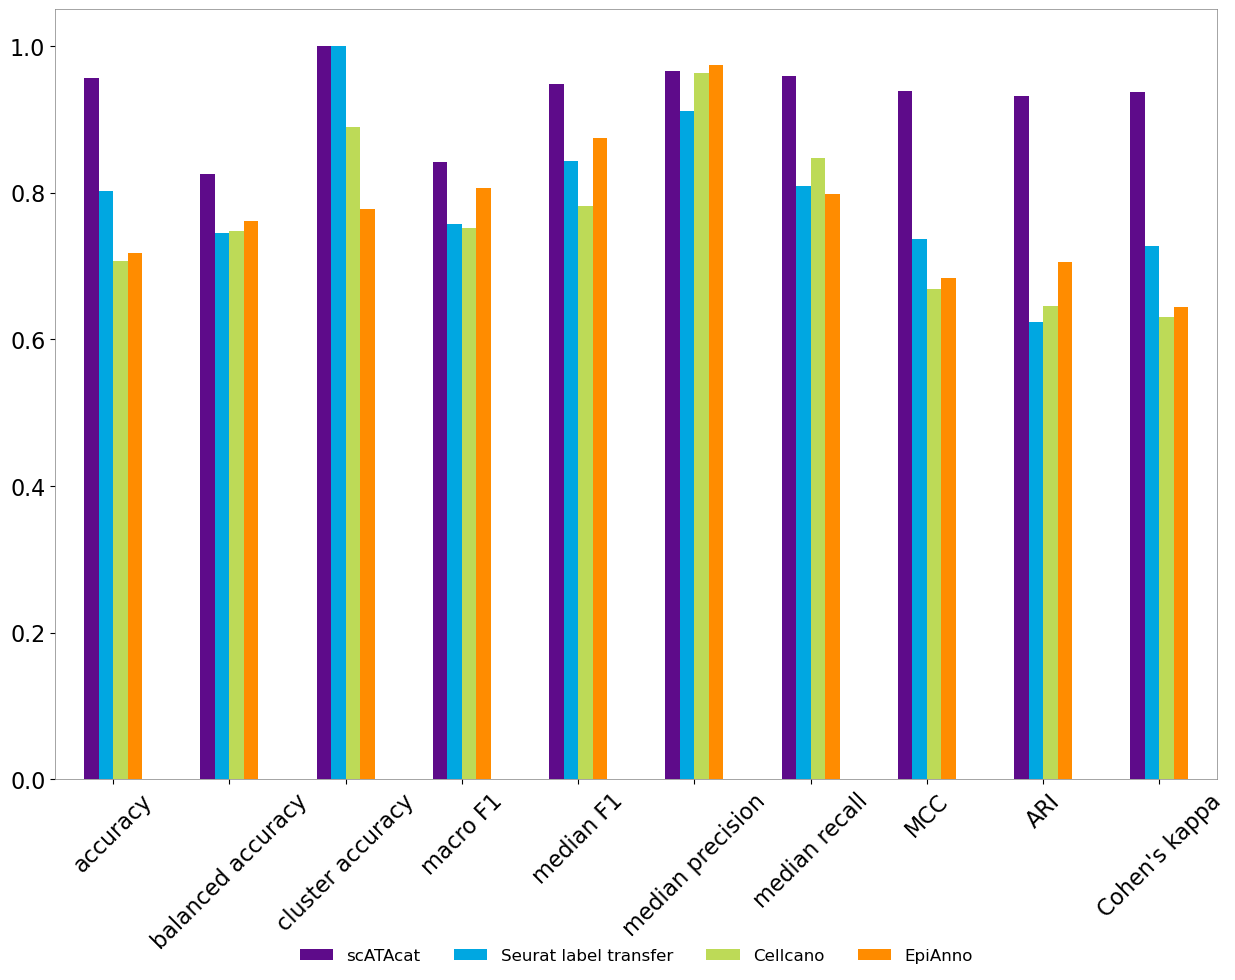

In [63]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_common_annotations.png',
                         labels = ['accuracy', 'balanced accuracy', 'cluster accuracy','macro F1', 'median F1','median precision', 'median recall','MCC', 'ARI', "Cohen's kappa"] )

In [64]:
scores_df.T.mean()

scATAcat                 0.930607
Seurat label transfer    0.795567
Cellcano                 0.763257
EpiAnno                  0.774399
dtype: object

## scores for common cells & pairwise common annotations


In [65]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_integration_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_integration_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_annotations = list(set(all_methods_for_commonCells.label_transfer_annotations)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations        
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_annotations = list(set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_annotations = list(set(all_methods_for_commonCells.EpiAnno_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [66]:
scores_df

,accuracy,balanced_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,cluster_accuracy
scATAcat,0.956703,0.825365,0.841425,0.948466,0.9661,0.959171,0.938899,0.932194,0.937751,1.0
Seurat_label_transfer,0.801832,0.74528,0.756673,0.84353,0.910843,0.808851,0.737476,0.624294,0.726889,1.0
Cellcano,0.706102,0.701987,0.694213,0.594595,0.95092,0.708571,0.667887,0.644097,0.629315,0.8
EpiAnno,0.717545,0.678634,0.71878,0.855478,0.968592,0.761905,0.684299,0.705524,0.645015,0.8


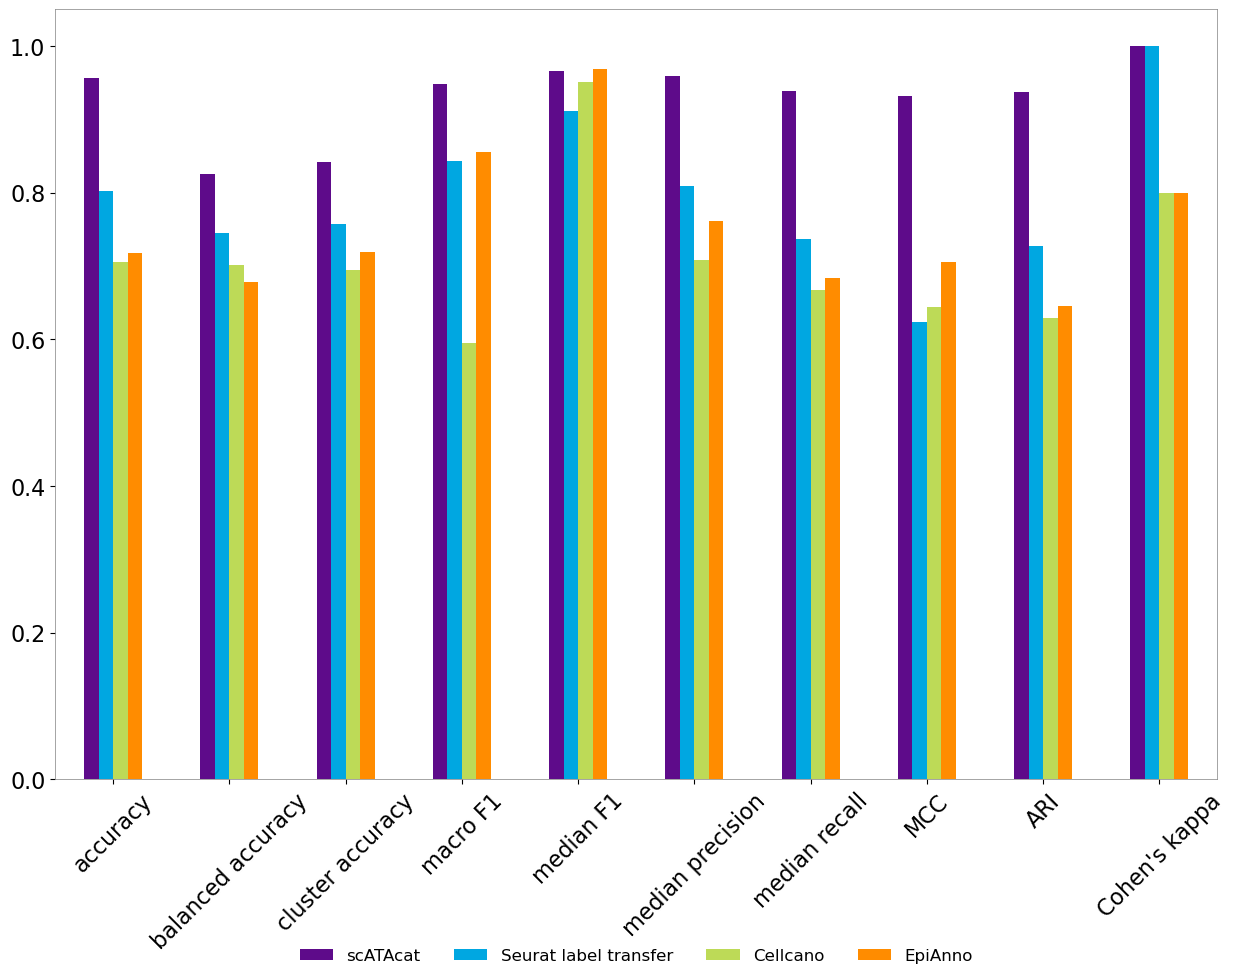

In [67]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_pairwise_common_annotations.png',
                         labels = ['accuracy', 'balanced accuracy', 'cluster accuracy','macro F1', 'median F1','median precision', 'median recall','MCC', 'ARI', "Cohen's kappa"] )

## scores for common cells - no filter for annotation

In [68]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
annotation_df = all_methods_for_commonCells
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [69]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.945679,0.495219,0.9,0.500225,0.581008,0.913352,0.516923,0.923828,0.92291,0.922453
Seurat_label_transfer,0.792593,0.447168,0.9,0.449579,0.482024,0.554634,0.447216,0.726306,0.619457,0.715928
Cellcano,0.7,0.491391,0.8,0.480841,0.49105,0.616149,0.425824,0.660268,0.64243,0.622928
EpiAnno,0.711934,0.542907,0.8,0.570952,0.681963,0.942351,0.61619,0.677262,0.703983,0.639114


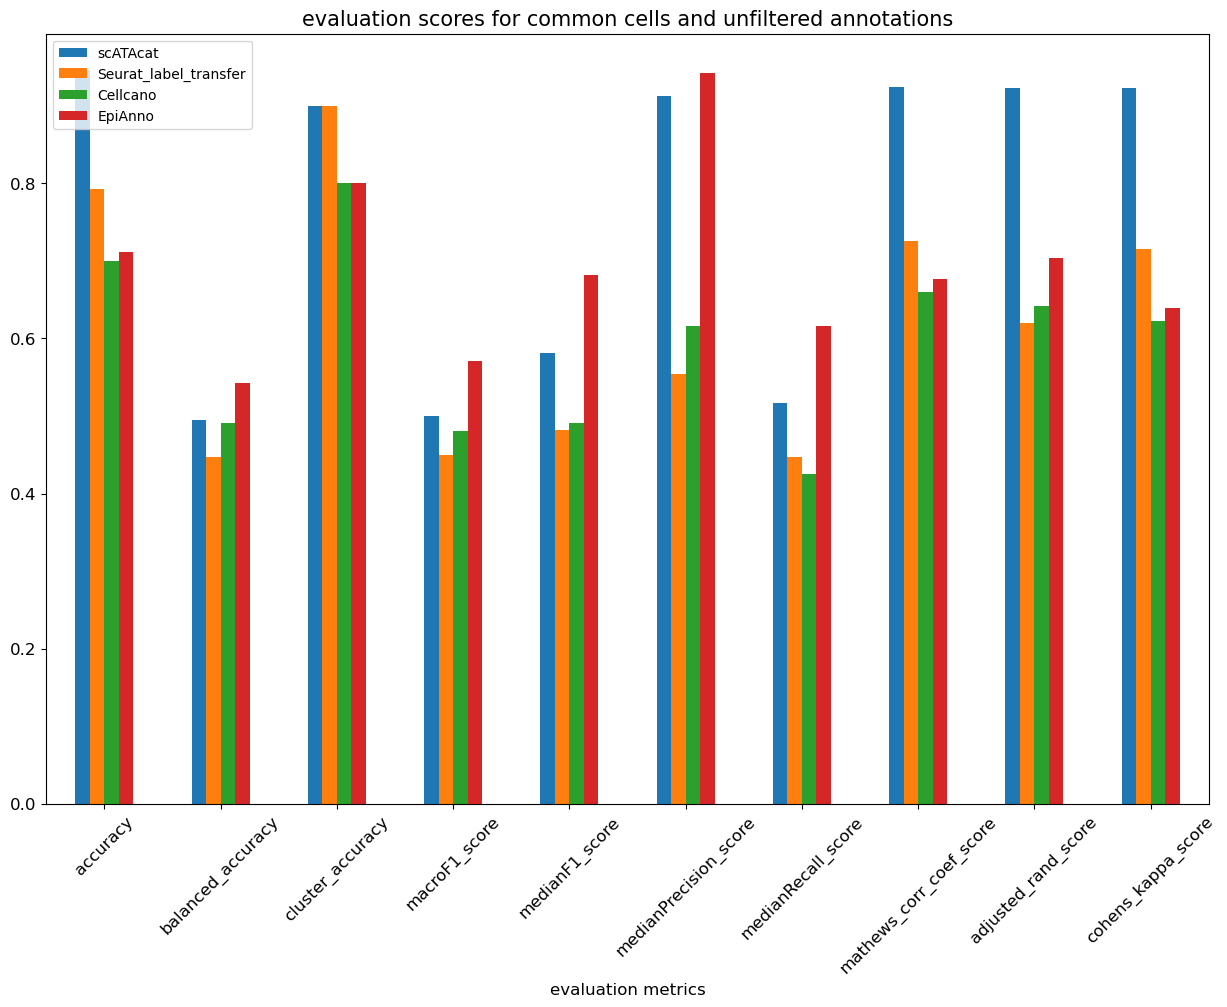

In [70]:
ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for common cells and unfiltered annotations", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/common_cells_unfiltered_annotations.png', bbox_inches='tight')

## scores for pairwise common cells - no annotation filter

In [71]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
#annotation_df = all_methods_for_commonCells
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        common_cells = get_common_cells(scATAcat_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        annotation_df = all_methods_for_commonCells
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_cells = get_common_cells(seurat_integration_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(seurat_integration_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        annotation_df = all_methods_for_commonCells
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_cells = get_common_cells(Cellcano_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(Cellcano_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        annotation_df = all_methods_for_commonCells
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_cells = get_common_cells(EpiAnno_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(EpiAnno_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        annotation_df = all_methods_for_commonCells
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


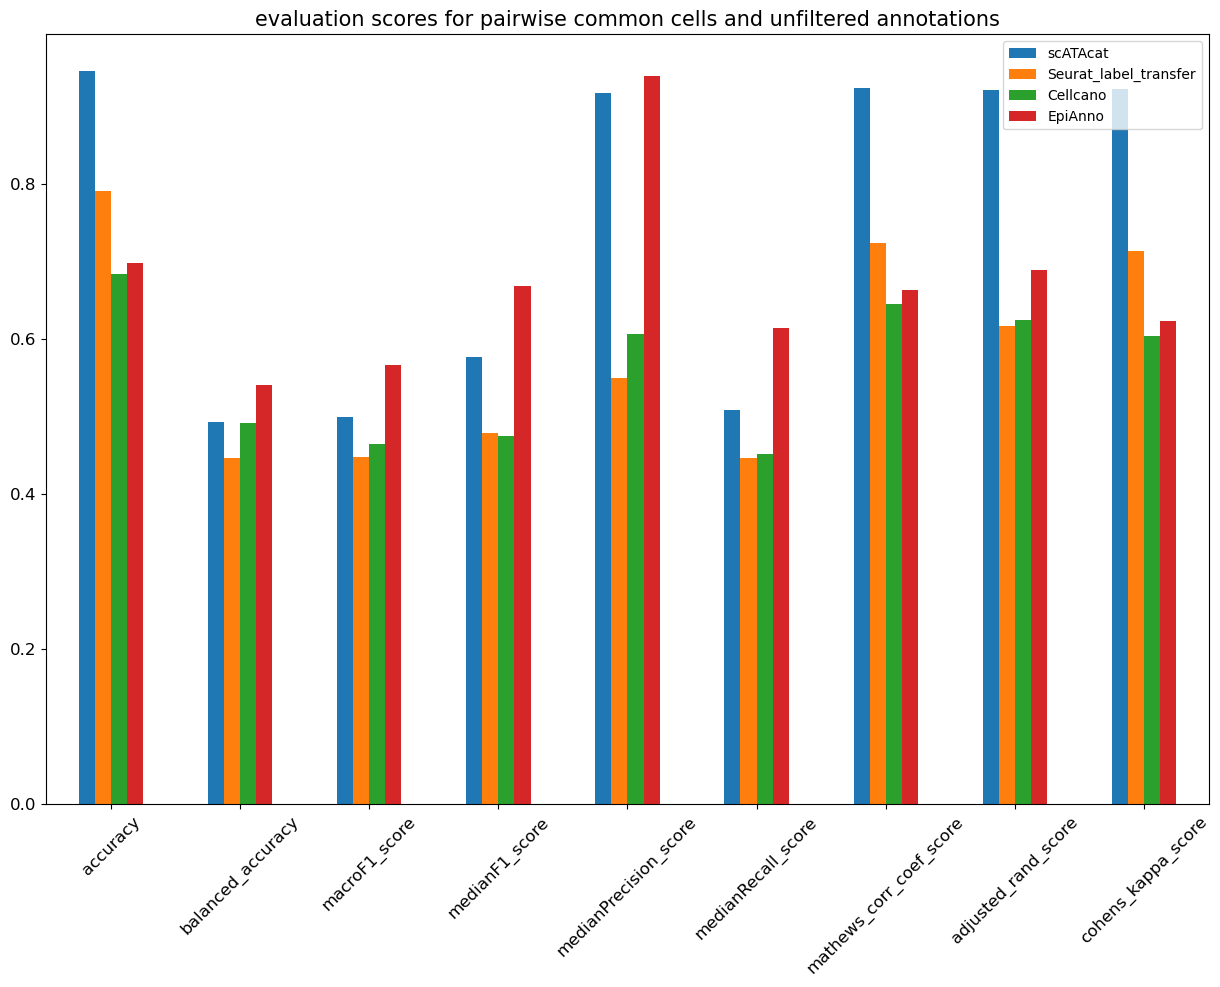

In [72]:
scores_dfax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for pairwise common cells and unfiltered annotations", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/pairwise_common_cells_unfiltered_annotations.png', bbox_inches='tight')

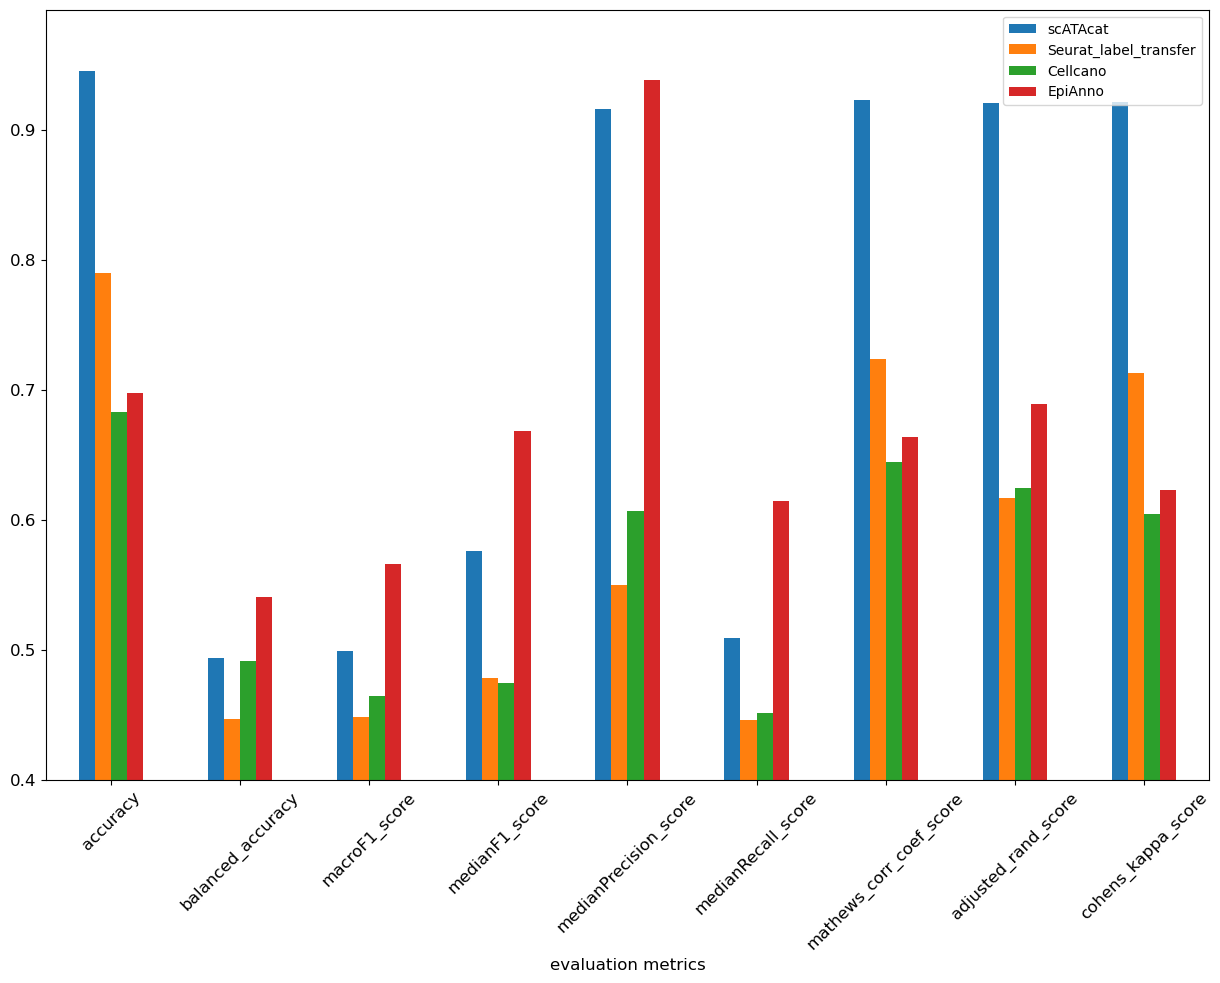

In [73]:
import matplotlib.pyplot as plt
ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.4)
plt.xticks(rotation=45)
plt.show()

## scores for pairwise common cells & pairwise common annotations


In [74]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
#annotation_df = all_methods_for_commonCells
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        common_cells = get_common_cells(scATAcat_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_cells = get_common_cells(seurat_integration_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(seurat_integration_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.label_transfer_annotations)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations        
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_cells = get_common_cells(Cellcano_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(Cellcano_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_cells = get_common_cells(EpiAnno_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(EpiAnno_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.EpiAnno_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


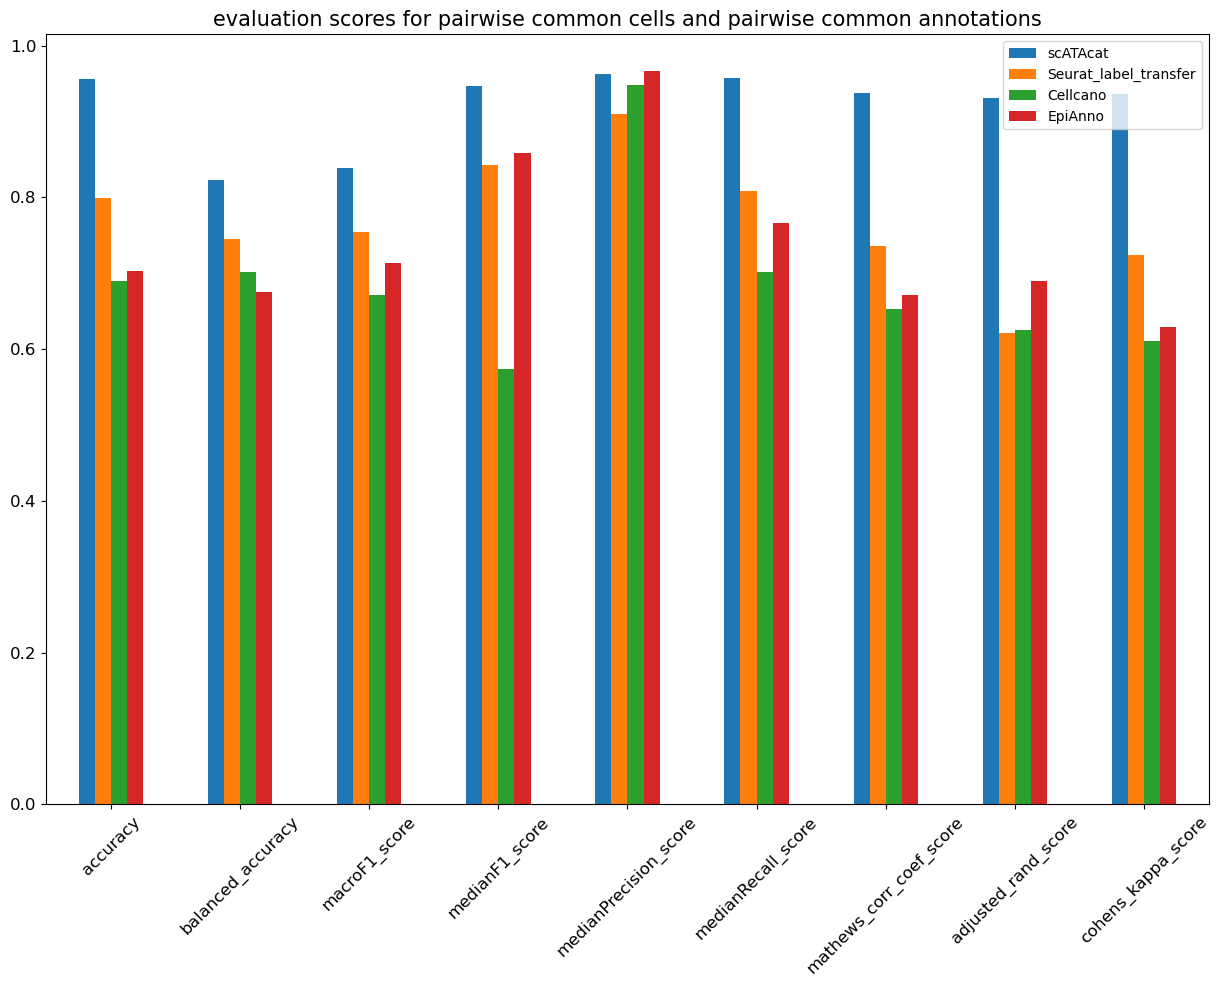

In [75]:
scores_dfax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for pairwise common cells and pairwise common annotations", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/pairwise_common_cells_pairwise_common_annotations.png', bbox_inches='tight')